In [1]:
# import: external libraries
import torch
import torchshow as ts
import matplotlib.pyplot as plt

from torchvision import transforms
from torch.utils.data import DataLoader
from torch import nn
from torch.nn import functional as F
from tqdm.notebook import tqdm
from pathlib import Path

print(f"cuda: {torch.cuda.is_available()}")

# import: solutions from the lessons
from underwater_imagery.models.model import Encoder, Decoder, EncoderDecoder

# import: own modules
from underwater_imagery.uim_dataset import UIMDataset

cuda: True


In [2]:
path = Path("./data/train_val/")
classes = [
    ('BW', torch.tensor([0, 0, 0], dtype=torch.uint8)),
    ('HD', torch.tensor([0, 0, 1], dtype=torch.uint8)),
    ('PF', torch.tensor([0, 1, 0], dtype=torch.uint8)),
    ('WR', torch.tensor([0, 1, 1], dtype=torch.uint8)),
    ('RO', torch.tensor([1, 0, 0], dtype=torch.uint8)),
    ('RI', torch.tensor([1, 0, 1], dtype=torch.uint8)),
    ('FV', torch.tensor([1, 1, 0], dtype=torch.uint8)),
    ('SR', torch.tensor([1, 1, 1], dtype=torch.uint8))
]

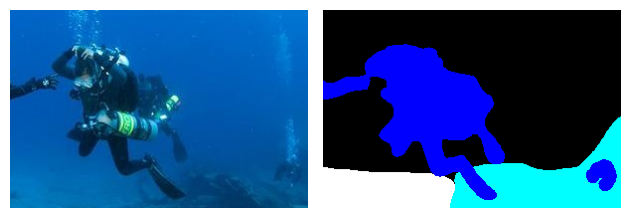

BW


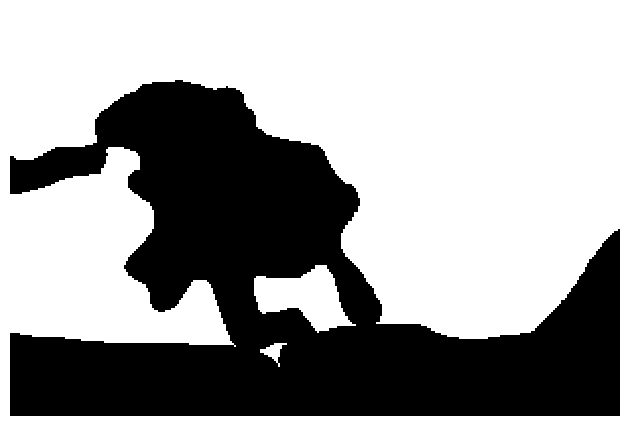

HD


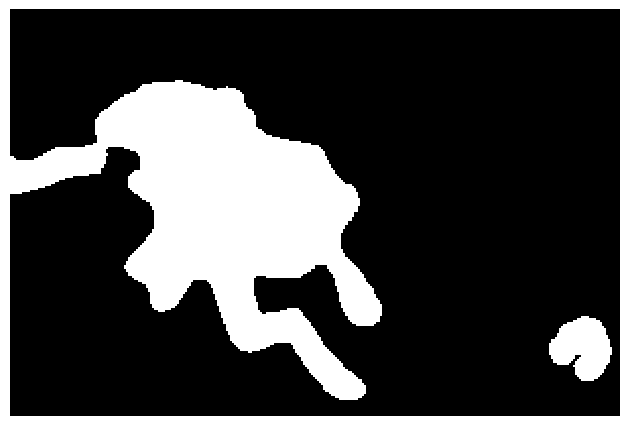

PF


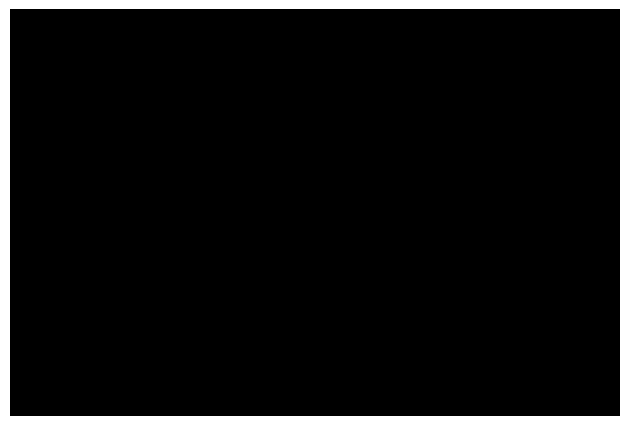

WR


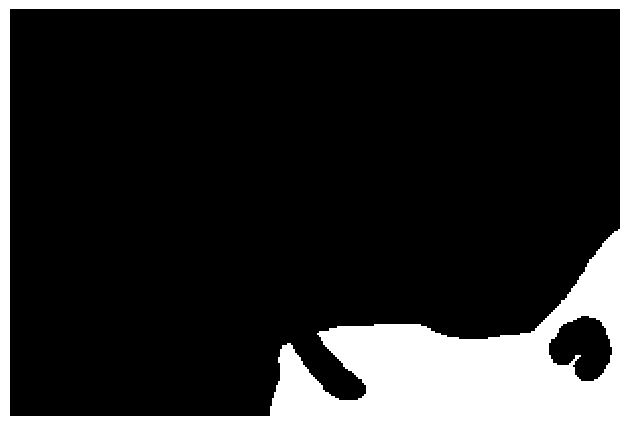

RO


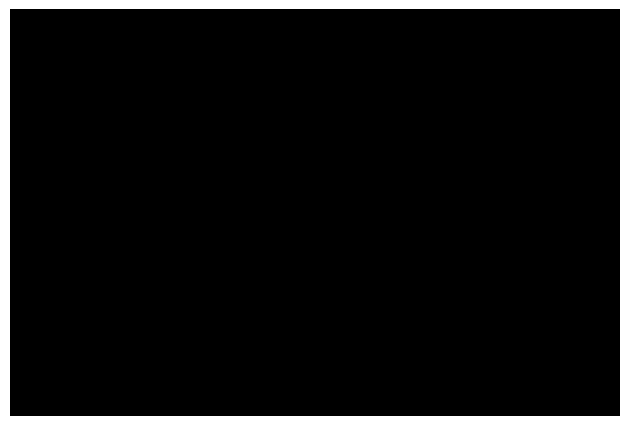

RI


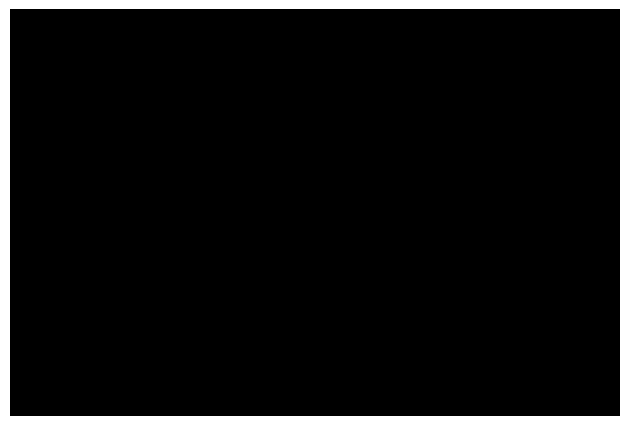

FV


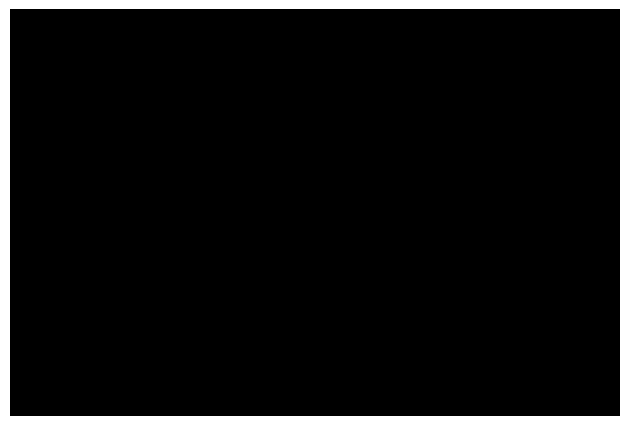

SR


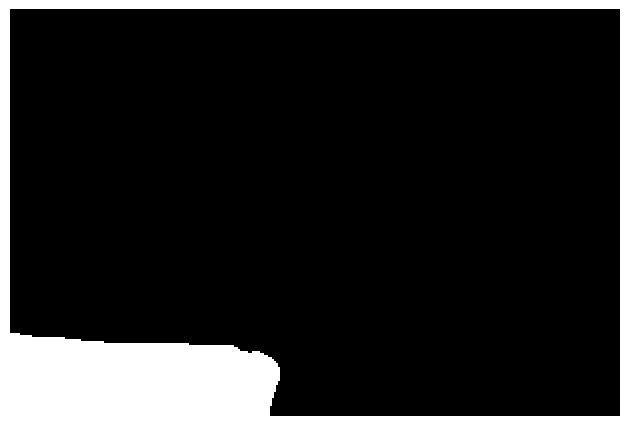

In [3]:
data = UIMDataset(path, classes)
img, mask, label = data[0]
ts.show([img, label])
plt.show()

for i, cls in enumerate(data.classes):
    print(cls[0])
    ts.show(mask[i, :, :]) 
    plt.show()

In [4]:
# Überprüfen der Architektur. Pro Klasse eine Maske und Input dim == Output dim.
num_channels = [16, 32, 64]
num_classes = len(data.classes)

encoder = Encoder(num_channels)
decoder = Decoder(list(reversed(num_channels)))
encoder_decoder = EncoderDecoder(
    encoder, 
    decoder, 
    num_initial_channels=16,
    num_input_channels=16,
    num_output_channels=num_classes
)

pred = encoder_decoder(img)
assert num_classes == pred.shape[0]
assert img.shape[1] == pred.shape[1]
assert img.shape[2] == pred.shape[2]

In [3]:
transf = transforms.Compose([
    transforms.ToTensor(),
    transforms.CenterCrop((200, 300)),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    transforms.ConvertImageDtype(torch.float),
])

transf_labels = transforms.Compose([
    transforms.ToTensor(),
    transforms.CenterCrop((200, 300)),
    transforms.ConvertImageDtype(torch.float),
])

ds = UIMDataset(path, classes, transform=transf, transform_labels=transf_labels)

In [4]:
import torch.optim as optim

torch.manual_seed(123)

# Parameters
num_epochs = 8

# create model
### BEGIN SOLUTION
num_channels = [16, 32, 64]
num_classes = len(ds.classes)
encoder = Encoder(num_channels)
decoder = Decoder(list(reversed(num_channels)))
encoder_decoder = EncoderDecoder(
    encoder, decoder, num_initial_channels=16, num_input_channels=16, num_output_channels=num_classes)
encoder_decoder.to('cuda')
### END SOLUTION

# Create Loss-Function and Optimizer
### BEGIN SOLUTION
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(encoder_decoder.parameters())
### END SOLUTION

for epoch in range(0, num_epochs):
    running_loss = 0.0
    running_acc = 0.0
    
    images = ds.images
    label_masks = ds.masks
    label_images = ds.label_images

    # Forward-Pass
    ### BEGIN SOLUTION
    optimizer.zero_grad()
    logits = encoder_decoder(images)
    probs = F.softmax(logits, dim=1)
    ### END SOLUTION
    
    # Optimize
    ### BEGIN SOLUTION
    loss = criterion(logits, label_masks)
    loss.backward()
    optimizer.step()
    ### END SOLUTION
    
print('Finished Training')

Finished Training


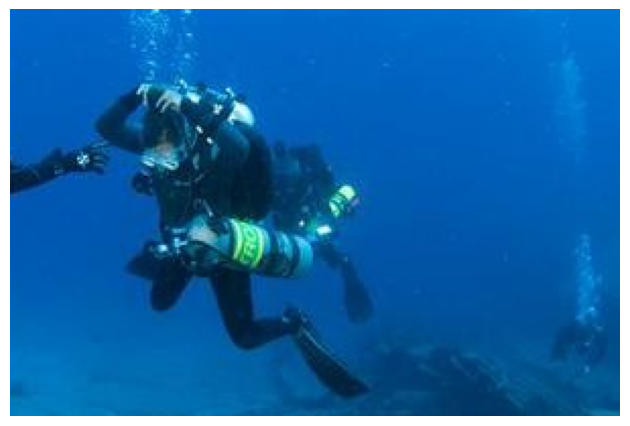

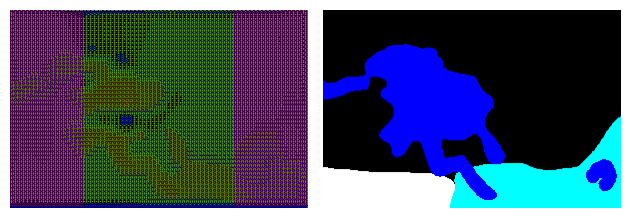

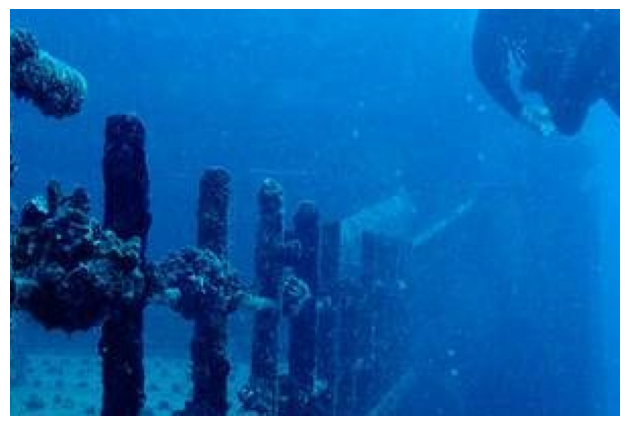

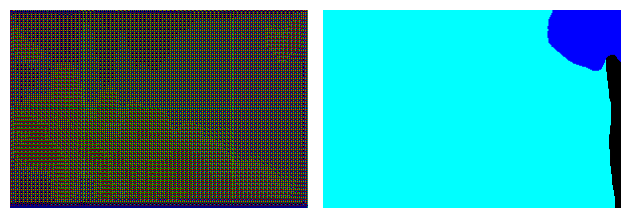

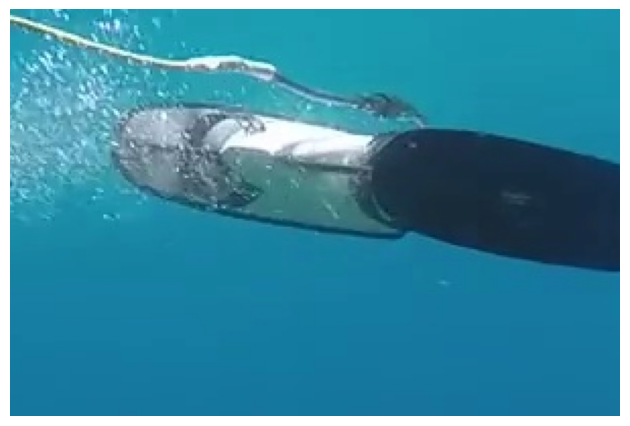

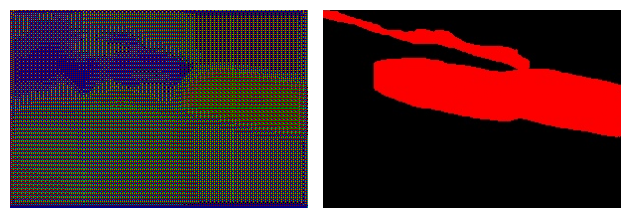

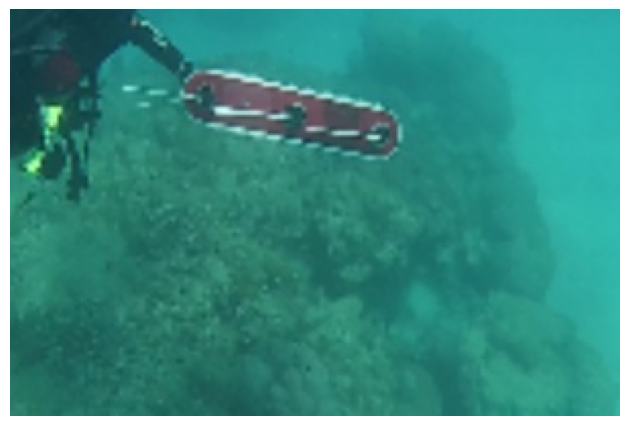

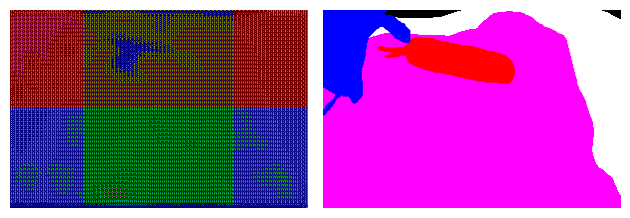

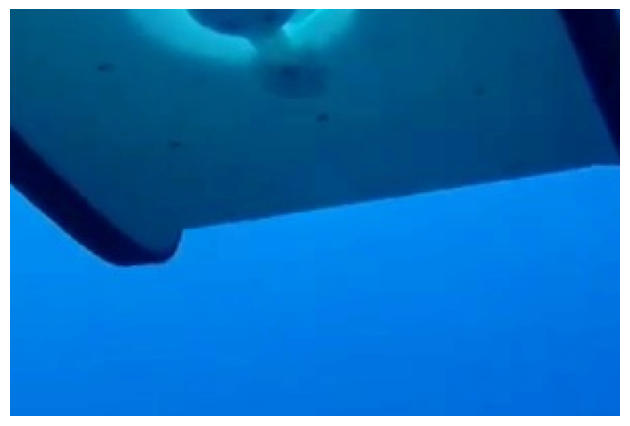

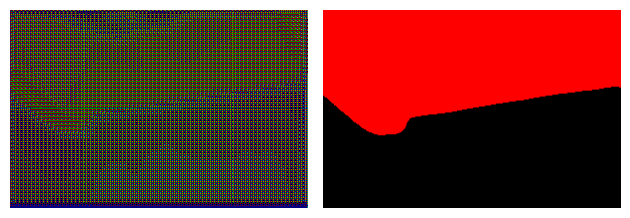

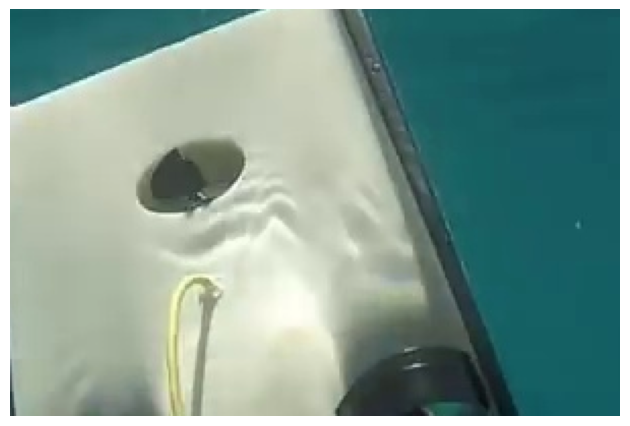

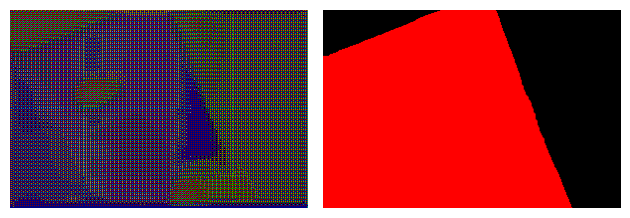

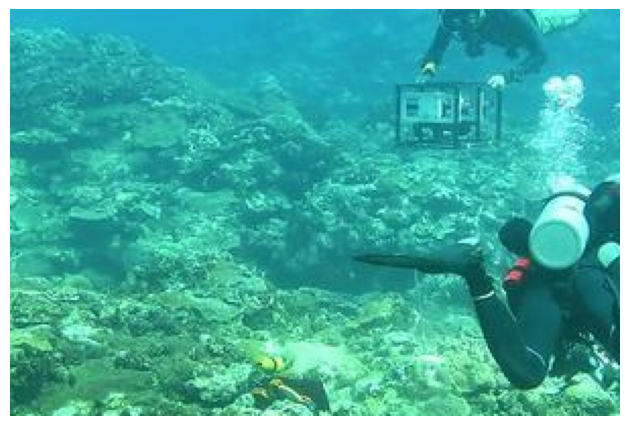

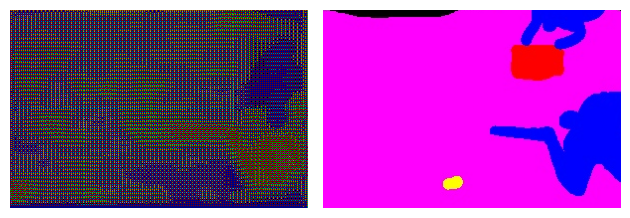

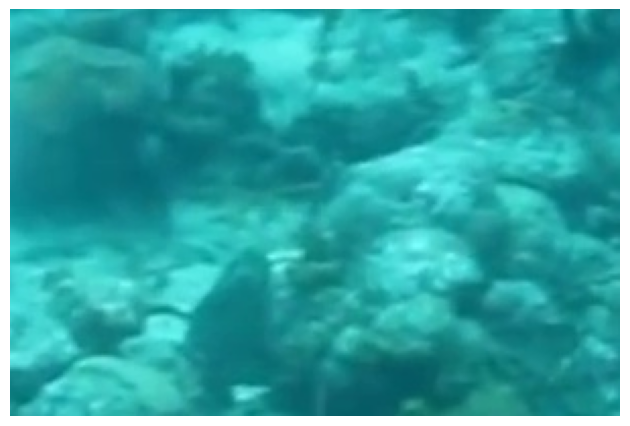

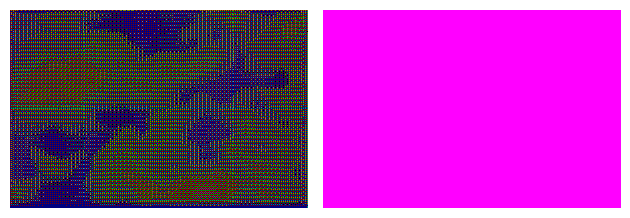

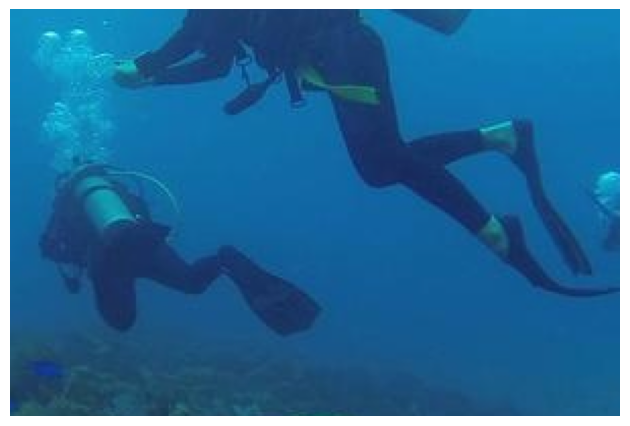

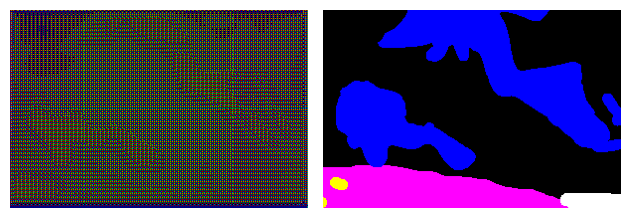

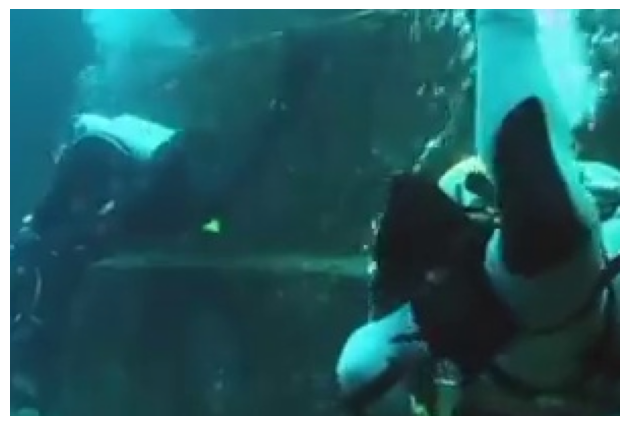

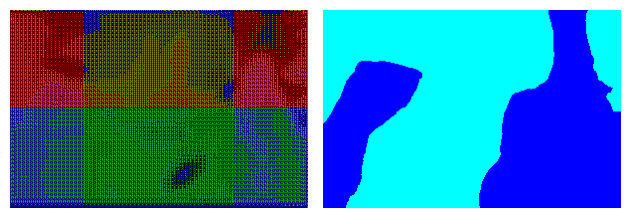

In [5]:
for i in range(10):
    images, _, label_images = ds[i]
    logits = encoder_decoder(images)
    ts.show(images)
    probs = F.softmax(logits, dim=1)
    pred = probs.argmax(dim=(0), keepdim=True)
    ts.show([pred, label_images])